In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import *

In [4]:
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks
# from imblearn.over_sampling import RandomOverSampler

In [5]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [6]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Getting Data

In [8]:
res = pd.read_csv('../Outputs/resampled.csv', encoding='cp949', index_col = 0)
test = pd.read_csv('../Outputs/test_set.csv', encoding='cp949', index_col = 0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [9]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [10]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 10, 100),
        'learning_rate':trial.suggest_float('learning_rate', 0.5, 1),
        'random_state':42
    }
    
    ada_model = AdaBoostClassifier(**params)
    ada_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred_prob = ada_model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_prob)                        
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [11]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

[I 2024-06-06 21:29:22,821] A new study created in memory with name: no-name-179ef6af-fef5-4275-ba34-daa5b29bc843
[I 2024-06-06 21:30:29,326] Trial 0 finished with value: 0.634711370713589 and parameters: {'n_estimators': 96, 'learning_rate': 0.7319857428685066}. Best is trial 0 with value: 0.634711370713589.
[I 2024-06-06 21:31:11,516] Trial 1 finished with value: 0.6331723662489683 and parameters: {'n_estimators': 40, 'learning_rate': 0.6124875464718448}. Best is trial 0 with value: 0.634711370713589.
[I 2024-06-06 21:31:32,344] Trial 2 finished with value: 0.6268405773992647 and parameters: {'n_estimators': 36, 'learning_rate': 0.9976704781930478}. Best is trial 0 with value: 0.634711370713589.
[I 2024-06-06 21:31:52,546] Trial 3 finished with value: 0.6285674992496435 and parameters: {'n_estimators': 38, 'learning_rate': 0.9365110085447401}. Best is trial 0 with value: 0.634711370713589.
[I 2024-06-06 21:32:22,344] Trial 4 finished with value: 0.6341170180835897 and parameters: {'n

In [19]:
ada_model = AdaBoostClassifier(**study.best_params, random_state = 42)
ada_model.fit(X_res, y_res)

AdaBoostClassifier(learning_rate=0.7240131816691515, n_estimators=80,
                   random_state=42)

### Making Predictions

In [20]:
y_pred = ada_model.predict(X_test)
y_pred_prob = pd.Series(ada_model.predict_proba(X_test)[:, 1])

### Plotting and Metrics

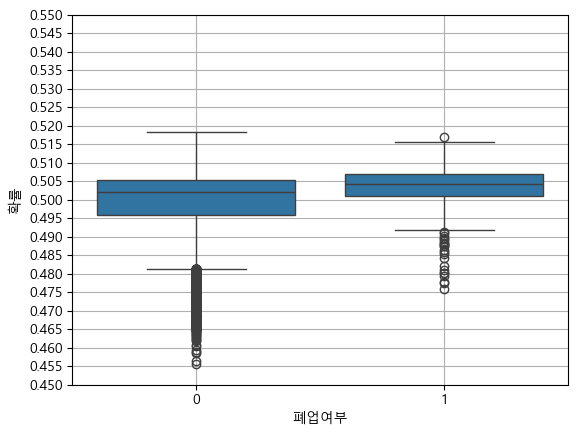

In [29]:
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.grid(True)
plt.ylim(0.45, 0.55)
plt.yticks(np.arange(0.45, 0.55, 0.005))
plt.show()

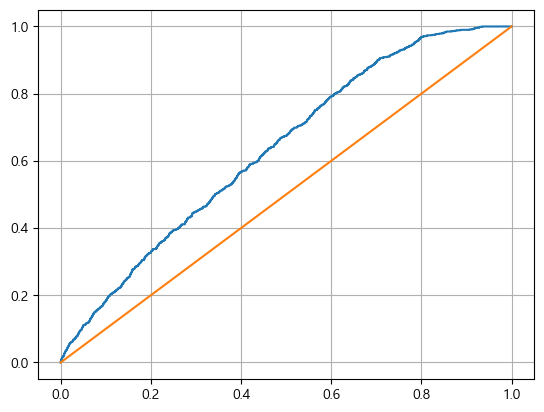

In [39]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='roc')
plt.plot([0, 1], [0, 1])
plt.grid()
plt.show()

In [35]:
threshold = 0.503
y_pred = (y_pred_prob >= threshold).astype('int')

In [36]:
print('accuracy :', accuracy_score(y_test, y_pred))
print('recall :', recall_score(y_test, y_pred))
print('precision :', precision_score(y_test, y_pred))
print('f1 score :', f1_score(y_test, y_pred))
print('roc :', roc_auc_score(y_test, y_pred_prob))

accuracy : 0.5667368965772159
recall : 0.59625
precision : 0.020214434038225197
f1 score : 0.03910316842234701
roc : 0.6349698919486757


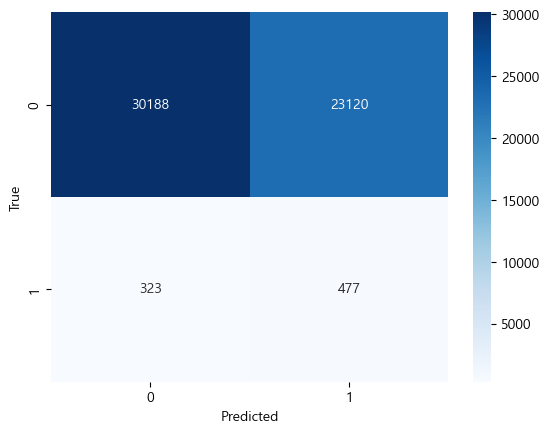

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

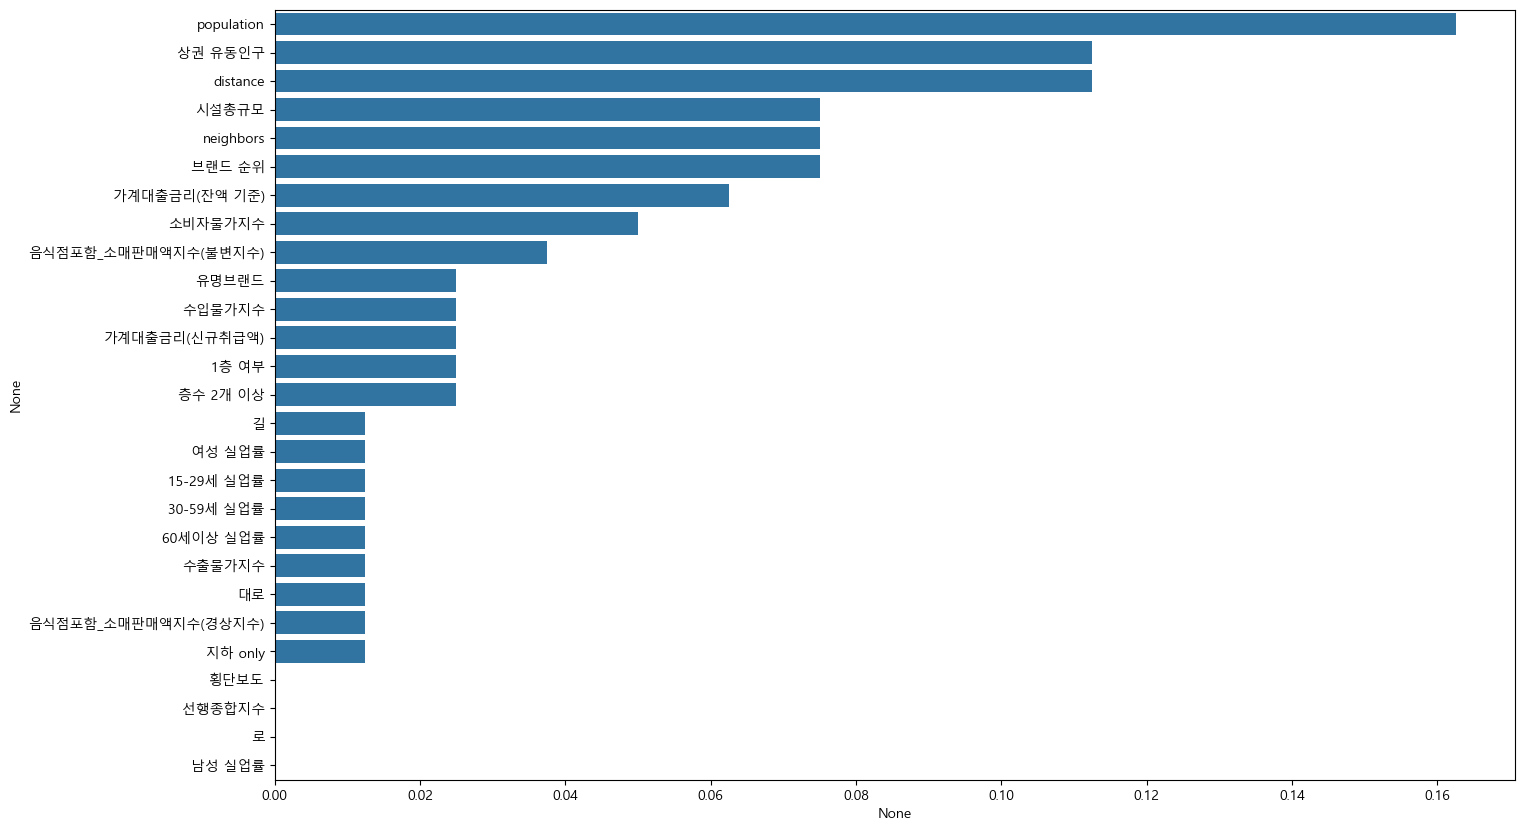

In [38]:
## Feature Importance
ser = pd.Series(ada_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()